In [105]:
%load_ext autoreload
%autoreload 2

from helpers import *

from IPython.display import clear_output

import bz2
import json

import pandas as pd

import numpy as np

from pprint import *

import matplotlib.pyplot as plt

# import pickle

# import sklearn as sk

# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# from scipy.sparse import vstack

# https://stackoverflow.com/questions/19798153/difference-between-map-applymap-and-apply-methods-in-pandas


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
path_to_file = QUOTES_2020_PATH

stats = {
    'count': 0,
    'quotation': {
        'chars': {
            'min_length': 1000000,
            'max_length': 0,
            'sum_length': 0,
            'length_bins': np.zeros(10000)
            },
            'words': {
            'min_length': 1000000,
            'max_length': 0,
            'sum_length': 0,
            'length_bins': np.zeros(10000)
        },
    }
}

i=0

# chunksize=10000

with pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=100000) as df_reader:
    for chunk in df_reader:
        print(i)

        #--------------------------------------------------------------------

        stats['count'] += chunk.shape[0]

        chunk_quote = chunk['quotation']
        #--------------------------------------------------------------------
        # Compute Quote Character Statistics

        stats_qc = stats['quotation']['chars']
        
        chunk_lengths = chunk_quote.map(lambda x: len(x))

        chunk_min_length = chunk_lengths.min()
        if stats_qc['min_length'] > chunk_min_length:
            stats_qc['min_length'] = chunk_min_length

        chunk_max_length = chunk_lengths.max()
        if stats_qc['max_length'] < chunk_max_length:
            stats_qc['max_length'] = chunk_max_length

        stats_qc['sum_length'] += chunk_lengths.sum()

        # stats_qc['length_bins'][chunk_lengths]+=np.bincount(chunk_lengths.to_numpy())[chunk_lengths]

        for l in chunk_lengths.to_numpy():
            stats_qc['length_bins'][l] += 1

        #--------------------------------------------------------------------
        # Compute Quote Word Statistics

        stats_qw = stats['quotation']['words']

        chunk_word_lengths = chunk_quote.map(lambda x: len(x.split(" ")))

        chunk_min_length = chunk_word_lengths.min()
        if stats_qw['min_length'] > chunk_min_length:
            stats_qw['min_length'] = chunk_min_length

        chunk_max_length = chunk_word_lengths.max()
        if stats_qw['max_length'] < chunk_max_length:
            stats_qw['max_length'] = chunk_max_length

        stats_qw['sum_length'] += chunk_word_lengths.sum()

        # stats_qw['length_bins'][chunk_word_lengths]+=np.bincount(chunk_word_lengths.to_numpy())[chunk_word_lengths]

        for l in chunk_word_lengths.to_numpy():
            stats_qw['length_bins'][l] += 1

        #--------------------------------------------------------------------

        i+=1
        # if i>2:
        #     break

stats['quotation']['chars']['avg_length'] = round(stats['quotation']['chars']['sum_length'] / stats['count'], 2)
stats['quotation']['words']['avg_length'] = round(stats['quotation']['words']['sum_length'] / stats['count'], 2)

# chunk.head()

clear_output(wait=True)
print("#Chunks=" + str(i))
print()
pprint(stats)

0
1
2
3
4
5
6
7
8
9
10
11


In [49]:
print(chunk.shape)
chunk.head()

(44449, 9)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
5200000,2020-01-18-041130,The price has moved up considerably from where...,John Murray,"[Q14248464, Q15456175, Q20621123, Q43912232, Q...",2020-01-18 02:51:28,1,"[[John Murray, 0.9178], [None, 0.0727], [Conor...",[https://www.reviewjournal.com/sports/betting/...,E
5200001,2020-04-02-060174,"The price is already up at £ 65,000 upwards. L...",None,[],2020-04-02 20:28:17,2,"[[None, 0.5587], [Chris Woakes, 0.3666], [Jos ...",[http://thedailystar.net/sports/cricket/news/e...,E
5200002,2020-02-04-084580,The primary requirement to prevent and manage ...,None,[],2020-02-04 03:04:09,1,"[[None, 0.9064], [Harsh Vardhan, 0.0936]]",[https://www.thehindubusinessline.com/news/cor...,E
5200003,2020-02-13-091159,The prime minister has a different opinion tha...,Jiří Ovčáček,[Q15290758],2020-02-13 23:50:00,1,"[[Jiří Ovčáček, 0.8658], [None, 0.1116], [Milo...",[http://msn.com/en-au/news/world/czech-prime-m...,E
5200004,2020-03-30-050268,The problem is the number of bank accounts I h...,John Smith,"[Q14948763, Q16225555, Q16674228, Q1701779, Q1...",2020-03-30 05:00:54,2,"[[John Smith, 0.8909], [None, 0.1091]]",[https://www.energyvoice.com/coronavirus/23158...,E


In [151]:
def plot_length_bins(bins, max_length):
    plt.bar(range(0,max_length), bins[:max_length], log=True)

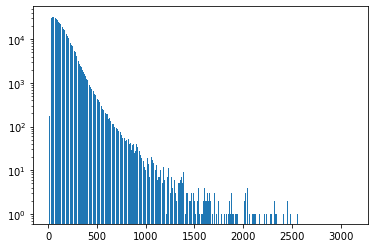

In [152]:
plot_length_bins(stats['quotation']['chars']['length_bins'], stats['quotation']['chars']['max_length'])

In [131]:
df_bins=pd.Series(bins)
df_bins

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9995    0.0
9996    0.0
9997    0.0
9998    0.0
9999    0.0
Length: 10000, dtype: float64

In [67]:
np.arange(10000)

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [76]:
chunk_lengths.to_numpy()


array([101,  83, 290, ..., 115,  72,  80])

In [74]:
np.zeros(10000)

array([0., 0., 0., ..., 0., 0., 0.])

In [81]:
bins = np.zeros(10000)
for l in chunk_lengths.to_numpy():
    bins[l] += 1

bins.sum()

44449.0